In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
#from torchsummary import summary
from torch.optim import lr_scheduler
from torchvision.models.resnet import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights

# Dataset
from GeoGuessrDataset import GeoGuessrDataset


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tnrange
import time
import copy
import pygeohash as phg


%matplotlib inline

# Enable autoreloading of imported modules.
%load_ext autoreload
%autoreload 2

In [73]:

import os
import sys
from PIL import Image

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import pandas as pd




def create_map_plot(coords, confidence, gt):
    """Create a map plot with the given coordinates.
    Args:
        coords (list): List of tuples with coordinates: (latitude, longitude)
    Returns:
        None
    """
    gt_new = np.zeros((2,2))
    gt_new[0,:]=gt
    gt_new[1,:]=gt
    gt_new = gt_new.tolist()
    df = pd.DataFrame(coords, columns=['lat', 'lng'])
    df["confidence"] = confidence
    df["confidence"] = (df["confidence"] / df["confidence"].sum()) * 50
    geometry = [Point(lng, lat) for lat, lng in coords]
    gdf = GeoDataFrame(df, geometry=geometry)
    # Set x-axis limits.
    
    df2 = pd.DataFrame(gt_new, columns=['lat', 'lng'])
    geometry2 = [Point(lng, lat) for lat, lng in gt_new]
    gdf2 = GeoDataFrame(df2, geometry=geometry2)
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color="#5c5c7e")
    gdf.plot(ax=ax, marker='o', color='red', markersize=gdf["confidence"])
    gdf2.plot(ax=ax, marker='o', color='yellow')

    #minx = min([point.x for point in geometry])
    #miny = min([point.y for point in geometry])
    #maxx = max([point.x for point in geometry])
    #maxy = max([point.y for point in geometry])
    plt.figure(figsize=(30, 15))
    #ax.set_xlim(minx - 20, maxx + 20)
    #ax.set_ylim(miny - 20, maxy + 20)
    plt.gca().set_axis_off()
    plt.gcf().set_size_inches(3.5, 1)
    plt.show()
    #plt.savefig(os.path.join(Config.PREDICTION_PLOT_PATH, 'prediction.png'), bbox_inches="tight", pad_inches=0.0, dpi=300)

In [44]:
dir = r"C:\Users\Shadow\Documents\sequentialmodel\preprocess"
ROOT_DIR = r'C:\Users\Shadow\Pictures\Geogussr\Projekt'
transform = transforms.Compose([transforms.ToTensor()])
dataset = GeoGuessrDataset(csv_file=dir+'\coordinates3.csv',
                                    root_dir=ROOT_DIR, transform=transform, num_classes=7)

dataset[0]['image'].shape

torch.Size([3, 512, 2560])

In [21]:
import pygeohash
def decimal_to_geohash(decimal):
    base_32 = '0123456789bcdefghjkmnpqrstuvwxyz'
    geohash = ''
    while decimal > 0:
        geohash += base_32[decimal % 32]
        decimal //= 32
    return geohash[::-1]

def geohash_to_lat_lon(geohash):
    return pygeohash.decode(geohash)

In [66]:
def create_geocode_mapping(path):
    """Create a dictionary with the geo_code as key and the geohash (decimal) as value
    Args:
        path (str): Path to the csv file with the coordinates
    Returns:
        dict: Dictionary with the geo_code as key and the geohash (decimal) as value
    """

    df = pd.read_csv(path)
    df_geo = df[["geohash_decimal", "geo_code"]]
    df_geo = df_geo.drop_duplicates()
    geo_code_to_geohash = dict(zip(df_geo["geo_code"], df_geo["geohash_decimal"]))
    return geo_code_to_geohash

Conti pred: Asia Conti gt:  Asia


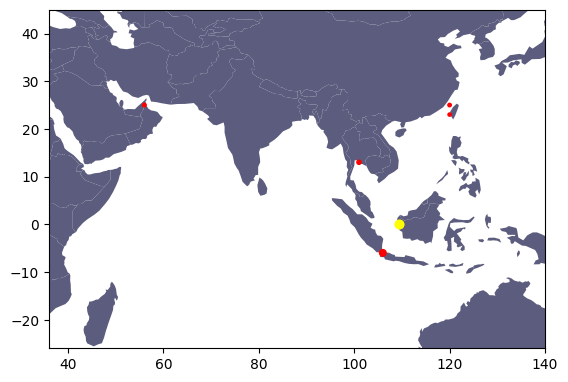

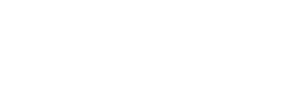

[-2.09323084e-03  1.09308640e+02]
Distance:  761.3568061661665


In [72]:
from haversine import haversine
# Load the model
geo_code_to_geohash = create_geocode_mapping(r"C:\Users\Shadow\Documents\sequentialmodel\preprocess\coordinates3.csv")

model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)

checkpoint = torch.load(r"C:\Users\Shadow\Documents\sequentialmodel\models\pretrainedresnet50_14epoch_contihead.tar", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

#transform = transforms.Compose([transforms.ToTensor()])
i = 1
image_transformed, gt, conti = dataset[i]['image'], dataset[i]['gt'], dataset[i]['conti']

with torch.inference_mode():
    # TODO: Why does the output tensor have 2 dimensions and why do we have to unsqueeze(0) add one dimension?
    # Probably because the model expects a batch of images, which adds an additional dimension?
    output = model(image_transformed.unsqueeze(0))[0]
    
    
    ############################# new stuff
    _, pred = torch.max(output,-1)
    
    if pred < 6:
        modelnames = ['SouthAmerica','Asia','Africa','oceania','northamerica','europe']
        
        print('Conti pred:' ,modelnames[pred],'Conti gt: ', modelnames[np.argmax(conti)] )
        model.fc = nn.Linear(num_ftrs, 3139)
        checkpoint = torch.load(r"C:\Users\Shadow\Documents\sequentialmodel\models\pretrainedresnet50_14epoch_"+modelnames[pred]+".tar", map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()

        output = model(image_transformed.unsqueeze(0))[0]
     ########################################
        
        

        
        # Return the top 5 predictions
        indices_sorted = np.argsort(-output)
        top5 = indices_sorted[:5]
        top_5_coords = [phg.decode(decimal_to_geohash(geo_code_to_geohash[int(index.data)])) for index in top5]

        prediction_confidence = nn.functional.softmax(output, dim=0)
        top5_predictions_confidence = prediction_confidence[top5]

        # Create a plot of the top 5 predictions
        
        create_map_plot(top_5_coords, top5_predictions_confidence.tolist(), gt)

        index = output.data.cpu().numpy().argmax()
        
        geohash_decimal = geo_code_to_geohash[index]
        
        geohash = decimal_to_geohash(geohash_decimal)
        
####################################### delete
        lat =  phg.decode(geohash)[0]
        lon = phg.decode(geohash)[1]
        print(gt)
        print('Distance: ',haversine(gt,(lat,lon)))
#########################################
    
    #### to determine, always predict fixed point for antarctica?
    else:
        print('antarctica')
    
    
    #logging.info(f"Geo-Code Prediction: {index}")
    #logging.info(f"Geohash Decimal Prediction: { geohash_decimal }")
    #logging.info(f"Geohash Code Prediction: { geohash }")
    #logging.info(f"Latitude, Longitude {pgh.decode(geohash)}")

    #result = {"geo-code": index, "geohash": geohash, "lat": pgh.decode(geohash)[0], "lon": pgh.decode(geohash)[1]}
    #result = {key: str(value) for key, value in result.items()}
    #print(json.dumps(result))